In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



In [ ]:
!pip install tensorflow keras matplotlib



In [8]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/fires-detection
/kaggle/input/fires-detection/Fire-Dataset
/kaggle/input/fires-detection/Fire-Dataset/valid
/kaggle/input/fires-detection/Fire-Dataset/train
/kaggle/input/indoor-training-set-its-residestandard
/kaggle/input/indoor-training-set-its-residestandard/trans
/kaggle/input/indoor-training-set-its-residestandard/clear


KeyboardInterrupt: 

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import shutil

In [9]:
dataset_directory = '/kaggle/input/fires-detection/Fire-Dataset/train'
search_extension = '.csv'  # Change this to your file extension, if known

files = os.listdir(dataset_directory)
matching_files = [file for file in files if file.endswith(search_extension)]

print(matching_files)

['_annotations.csv.csv']


In [10]:
annotations = pd.read_csv('/kaggle/input/fires-detection/Fire-Dataset/train/_annotations.csv.csv')
annotations=annotations.dropna(how='all')
# Example: Adjust column names based on your CSV structure
shuffled_df = annotations.sample(frac=1).reset_index(drop=True)




In [11]:
image_paths = shuffled_df['filename'].values
fire_labels = shuffled_df['class'].values

# Encode labels if necessary (e.g., 'yes'/'no' to 1/0)
# label_encoder = LabelEncoder()
# fire_labels = label_encoder.fit_transform(fire_labels)

In [12]:
# Split data into training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, fire_labels, test_size=0.2, random_state=42
)

In [13]:
#Fire-Dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Function to load and preprocess images
def load_data(image_paths, labels, datagen, batch_size=32):
    generator = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': image_paths, 'label': labels}),
        directory='/kaggle/input/fires-detection/Fire-Dataset/train',
        x_col='filename',
        y_col='label',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    
    return generator

train_generator = load_data(train_paths, train_labels, train_datagen)
val_generator = load_data(val_paths, val_labels, val_datagen)


Found 6632 validated image filenames belonging to 2 classes.
Found 1658 validated image filenames belonging to 2 classes.


In [18]:
# Paths to the dataset folders
# train_dir = '/kaggle/input/firedataset-jpg-224/FireDataset-V6-JPG-Reshaped224/train'
# val_dir = '/kaggle/input/firedataset-jpg-224/FireDataset-V6-JPG-Reshaped224/val'
test_dir = '/kaggle/input/firedataset-jpg-224/FireDataset-V6-JPG-Reshaped224/test'

## ImageDataGenerator for data augmentation and normalization
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# # ImageDataGenerator for validation and test (only rescaling)
# val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# # Load images from directories
# train_generator = train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(150, 150),
#     batch_size=32,
#     class_mode='binary'
# )

# val_generator = val_datagen.flow_from_directory(
#     val_dir,
#     target_size=(150, 150),
#     batch_size=32,
#     class_mode='binary'
# )

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 4014 images belonging to 2 classes.
Found 492 images belonging to 2 classes.
Found 524 images belonging to 2 classes.


In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [23]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 116s 912ms/step - accuracy: 0.5975 - loss: 0.6847 - val_accuracy: 0.8354 - val_loss: 0.4658
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step - accuracy: 0.9375 - loss: 0.2144 - val_accuracy: 0.9167 - val_loss: 0.2616
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 143s 929ms/step - accuracy: 0.8414 - loss: 0.3921 - val_accuracy: 0.8667 - val_loss: 0.3491
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step - accuracy: 0.9375 - loss: 0.2152 - val_accuracy: 0.9167 - val_loss: 0.5212
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 118s 928ms/step - accuracy: 0.8719 - loss: 0.3177 - val_accuracy: 0.8875 - val_loss: 0.3044
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 758us/step - accuracy: 0.7812 - loss: 0.4180 - val_accuracy: 0.9167 - val_loss: 0.2561
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 117s 922ms/step - accuracy: 0.8877 - loss: 0.2752 - val_accuracy: 0.9021 - val_loss: 0.2687
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step - accuracy: 0.8750 - loss: 0

In [24]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_acc:.2f}')


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step - accuracy: 0.8374 - loss: 0.5118
Test accuracy: 0.89


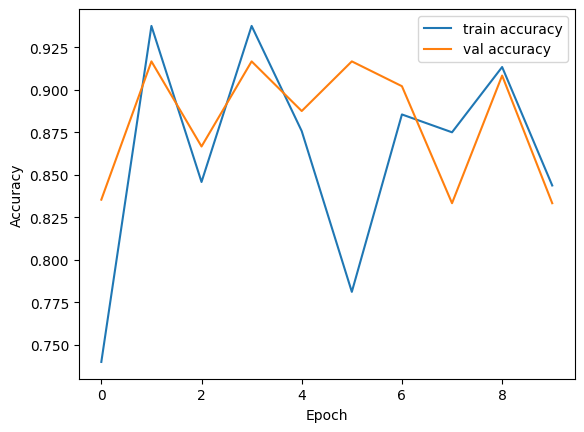

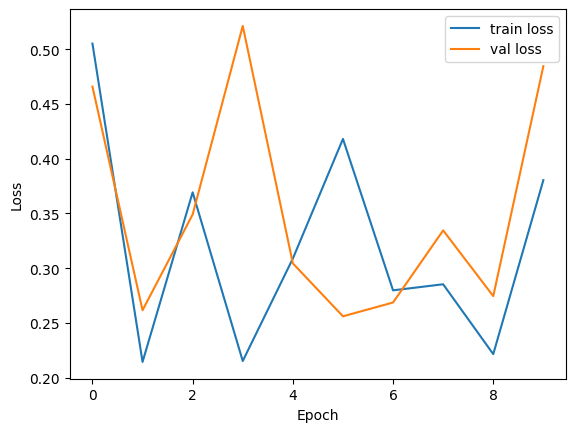

In [25]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [26]:
val_loss, val_accuracy = model.evaluate(val_generator, steps=val_generator.samples // 32)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print(f'Validation Loss: {val_loss:.2f}')


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.8909 - loss: 0.3029
Validation Accuracy: 0.88
Validation Loss: 0.32
